In [1]:
# Cell 1: Setup and Imports
import re
import os
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.stats import entropy
warnings.filterwarnings('ignore')
from itertools import combinations
from joblib import Parallel, delayed
from geopy.geocoders import Nominatim
from torch_geometric.nn import GCNConv
from sklearn.model_selection import KFold
from torch_geometric.data import HeteroData
from sklearn.preprocessing import MinMaxScaler
from geopy.extra.rate_limiter import RateLimiter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuration
DATA_PATH = "Incidents_imputed.xlsx"
CACHE_FILE = "geocoded_cache.parquet"
MAX_WORKERS = 4 

In [2]:
# Cell 2: Data Loader with Chunking
def load_data():
    # Read Excel with type inference and chunking
    #cols = ['Job Substation', 'Job OFF Time', 'Job ON Time', 'Job Duration Mins',
       #     'Cause Desc', 'Device Address_imputed', 'Job City_imputed']
    
    return pd.read_excel(
        DATA_PATH,
        #usecols=cols,
        parse_dates=['Job OFF Time', 'Job ON Time'],
        dtype={'Cause Desc': 'category'},
        engine='openpyxl'
    )

df = load_data()
cutoff_date = df['Job OFF Time'].max() - pd.DateOffset(years=2)
print(f"Loaded {len(df)} records")

Loaded 292829 records


In [6]:
# Cell 3: Target Varaible 

hetero_graph = torch.load("power_grid_graph_base.pt")

# Assuming 'df' is your incident dataset and 'cutoff_date' is defined as before
# Define the target window: 180 days after the cutoff date
target_start = cutoff_date  # starting at the cutoff_date
target_end = cutoff_date + pd.Timedelta(days=180)

# Filter incidents to the target window
target_df = df[(df['Job OFF Time'] > target_start) & (df['Job OFF Time'] <= target_end)].copy()

# For each substation, calculate the maximum incident duration in this period
max_duration_df = target_df.groupby('Job Substation')['Job Duration Mins'].max().reset_index()

print("Sample of computed maximum durations:")
print(max_duration_df.head())

# Create a dictionary mapping each substation to its maximum incident duration
target_dict = dict(zip(max_duration_df['Job Substation'], max_duration_df['Job Duration Mins']))

# Get the substation ordering from the hetero_graph
node_order = hetero_graph['substation'].node_order.tolist()

# Create the target list: if a substation is missing from target_dict, assign 0 (or another default)
target_list = [target_dict.get(substation, 0.0) for substation in node_order]

# Convert to a torch tensor (float32 for regression)
target_tensor = torch.tensor(target_list, dtype=torch.float32)

# Merge the target into the graph under the node type 'substation'
hetero_graph['substation'].y = target_tensor

print("\nTarget variable merged successfully!")
print("Target tensor shape:", target_tensor.shape)
print("Target distribution (first 10 entries):", target_tensor[:10])


Sample of computed maximum durations:
       Job Substation  Job Duration Mins
0  3109:HONOR HEIGHTS             916.30
1      3110:RIVERSIDE             599.30
2    3111:FIVE TRIBES            1082.98
3       3114:TENNYSON            1068.70
4   3117:THREE RIVERS             389.03

Target variable merged successfully!
Target tensor shape: torch.Size([339])
Target distribution (first 10 entries): tensor([ 916.3000,  599.3000, 1082.9800, 1068.7000,    0.0000,  389.0300,
         840.7700,    0.0000,  210.9800,  620.3700])


In [8]:

# Revised Weighted Convolution Module for the Regression Pipeline
class WeightedGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels, edge_attr_dim):
        """
        in_channels: Dimension of node features.
        out_channels: Desired output feature dimension.
        edge_attr_dim: Dimension of the edge attributes.
        """
        super(WeightedGCNConv, self).__init__()
        # MLP to compute a scalar weight from each edge's attributes.
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_attr_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Ensures weights are in the range [0, 1]
        )
        # GCN convolution that will use these computed edge weights.
        self.gcn = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        """
        x: Node feature matrix.
        edge_index: Graph connectivity.
        edge_attr: Attributes for each edge.
        """
        # Compute a weight for each edge based on its attributes.
        weight = self.edge_mlp(edge_attr)
        # Squeeze the weight tensor from shape [num_edges, 1] to [num_edges]
        weight = weight.squeeze(-1)
        # Apply the GCN convolution with the computed edge weights.
        out = self.gcn(x, edge_index, edge_weight=weight)
        return out


In [9]:

class MultiLayerWeightedHeteroGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_attr_dims, num_layers=2, dropout_rate=0.5):
        """
        A Multi-Layer Heterogeneous Graph Neural Network with relation-specific weighted convolutions
        adapted for regression.

        Args:
            in_channels (int): Input feature dimensions.
            hidden_channels (int): Hidden layer feature dimensions.
            out_channels (int): Output feature dimensions (for regression, typically 1).
            edge_attr_dims (dict): Mapping relation type to its edge attribute dimension.
                                   Example: {'spatial': 3, 'temporal': 2, 'causal': 3}
            num_layers (int, optional): Number of graph convolution layers. Defaults to 2.
            dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.5.
        """
        super(MultiLayerWeightedHeteroGNN, self).__init__()

        # Build multiple layers of relation-specific weighted convolutions
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        for _ in range(num_layers):
            # Create a dictionary of convolution modules for each edge type
            layer = nn.ModuleDict({
                'spatial': WeightedGCNConv(in_channels, hidden_channels, edge_attr_dims['spatial']),
                'temporal': WeightedGCNConv(in_channels, hidden_channels, edge_attr_dims['temporal']),
                'causal': WeightedGCNConv(in_channels, hidden_channels, edge_attr_dims['causal']),
            })
            self.layers.append(layer)

            # Batch normalization and dropout for each layer
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
            self.dropouts.append(nn.Dropout(dropout_rate))

            # For the next layer, input size becomes hidden_channels
            in_channels = hidden_channels

        # Final prediction head for regression
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        """
        Forward pass of the heterogeneous GNN.

        Args:
            data (HeteroData): PyG Heterogeneous Graph Data containing node features and edge indices/attributes.

        Returns:
            torch.Tensor: Output predictions (for regression, a continuous value per node).
        """
        # Extract node features for substation nodes
        x = data['substation'].x  

        # Process each layer
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            messages = []
            for rel in ['spatial', 'temporal', 'causal']:
                # Extract edge index and edge attributes for the given relation type
                edge_index = data['substation', rel, 'substation'].edge_index
                edge_attr = data['substation', rel, 'substation'].edge_attr
                messages.append(layer[rel](x, edge_index, edge_attr))
            
            # Aggregate messages (using a sum operation)
            x = sum(messages)

            # Apply batch normalization
            x = bn(x)
            # Apply ReLU activation
            x = F.relu(x)
            # Apply dropout for regularization
            x = dropout(x)

        # Final prediction layer
        out = self.lin(x)
        # If out_channels == 1, squeeze the last dimension for a [num_nodes] shape output
        if out.size(1) == 1:
            out = out.squeeze(1)
        return out


In [10]:
import torch.optim as optim

# --- Define Edge Attribute Dimensions ---
edge_attr_dims = {
    'spatial': 3,  # e.g., [distance, shared_cities, shared_feeders]
    'temporal': 2,  # e.g., [time_diff, event_count]
    'causal': 3     # e.g., [shared_causes, mean_time_lag, spatial_distance]
}

# --- Instantiate the Model for Regression ---
in_channels = hetero_graph['substation'].x.shape[1]  # number of node features
hidden_channels = 64     # can be tuned
num_layers = 2

# For regression, we output a single continuous value (out_channels = 1)
model = MultiLayerWeightedHeteroGNN(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=1,   # regression output: continuous value per node
    edge_attr_dims=edge_attr_dims,
    num_layers=num_layers
)

# --- Move Model and Data to Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
hetero_graph = hetero_graph.to(device)

# --- The target is already merged as continuous values into hetero_graph['substation'].y ---
# No label encoding is necessary.

# --- Define Loss and Optimizer ---
criterion = torch.nn.MSELoss()  # for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

# Learning Rate Scheduler & Early Stopping
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
best_val_loss = float('inf')
patience = 20
counter = 0

# --- Create Train/Validation/Test Masks ---
num_nodes = hetero_graph['substation'].x.shape[0]  
indices = torch.randperm(num_nodes)

train_split = int(0.7 * num_nodes)  # 70% Training
val_split = int(0.85 * num_nodes)     # 15% Validation, 15% Test

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
val_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
test_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

hetero_graph['substation'].train_mask = train_mask
hetero_graph['substation'].val_mask = val_mask
hetero_graph['substation'].test_mask = test_mask

# --- Training Loop ---
num_epochs = 200
model.train()

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    # Forward pass: output shape should be [num_nodes] after squeezing
    out = model(hetero_graph)  # regression output: continuous value per node
    
    # Compute training loss (MSE)
    train_loss = criterion(out[train_mask], hetero_graph['substation'].y[train_mask])
    train_loss.backward()
    optimizer.step()
    
    # Validation loss computation
    with torch.no_grad():
        val_loss = criterion(out[val_mask], hetero_graph['substation'].y[val_mask])
    
    # Update the learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

    # Logging every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

# --- Load Best Model Before Testing ---
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# --- Testing & Evaluation ---
with torch.no_grad():
    out = model(hetero_graph)  # Shape: [num_nodes]
    test_loss = criterion(out[test_mask], hetero_graph['substation'].y[test_mask])
    rmse = torch.sqrt(test_loss)
    
print(f"Test MSE: {test_loss:.4f} | Test RMSE: {rmse:.4f}")


Epoch 10/200 - Train MSE: 5651222.0000 | Val MSE: 2034286.6250
Epoch 20/200 - Train MSE: 5644459.5000 | Val MSE: 2030432.3750
Epoch 30/200 - Train MSE: 5636766.0000 | Val MSE: 2024785.0000
Epoch 40/200 - Train MSE: 5625621.5000 | Val MSE: 2020520.2500
Epoch 50/200 - Train MSE: 5620045.5000 | Val MSE: 2018185.7500
Epoch 60/200 - Train MSE: 5595304.0000 | Val MSE: 2002431.7500
Epoch 70/200 - Train MSE: 5568243.5000 | Val MSE: 1987360.2500
Epoch 80/200 - Train MSE: 5533356.0000 | Val MSE: 1966792.2500
Epoch 90/200 - Train MSE: 5517613.0000 | Val MSE: 1963640.8750
Epoch 100/200 - Train MSE: 5464360.0000 | Val MSE: 1958288.7500
Epoch 110/200 - Train MSE: 5448718.5000 | Val MSE: 1940970.2500
Epoch 120/200 - Train MSE: 5334849.0000 | Val MSE: 1929323.2500
Epoch 130/200 - Train MSE: 5271732.0000 | Val MSE: 1920590.3750
Early stopping triggered!
Test MSE: 3916987.7500 | Test RMSE: 1979.1382


In [11]:
import torch.optim as optim
import torch.nn.functional as F

# ===========================
# STEP 1: Transform the Target
# ===========================
# We apply a log transformation (log(y + 1)) to stabilize the variance.
# (Assuming hetero_graph['substation'].y contains the continuous target in minutes.)
hetero_graph['substation'].y = torch.log(hetero_graph['substation'].y + 1)

# ===========================
# STEP 2: Define Model and Hyperparameters
# ===========================
edge_attr_dims = {
    'spatial': 3,   # e.g., [distance, shared_cities, shared_feeders]
    'temporal': 2,  # e.g., [time_diff, event_count]
    'causal': 3     # e.g., [shared_causes, mean_time_lag, spatial_distance]
}
in_channels = hetero_graph['substation'].x.shape[1]  # number of node features
hidden_channels = 64     # can be tuned
num_layers = 2

# For regression we output a single continuous value (out_channels=1)
model = MultiLayerWeightedHeteroGNN(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=1,   # regression output
    edge_attr_dims=edge_attr_dims,
    num_layers=num_layers
)

# Move model and data to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
hetero_graph = hetero_graph.to(device)

# ===========================
# STEP 3: Define Loss, Optimizer, and Scheduler
# ===========================
criterion = torch.nn.MSELoss()  # MSE loss in log-space
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

# ===========================
# STEP 4: Create Train/Val/Test Masks
# ===========================
num_nodes = hetero_graph['substation'].x.shape[0]  
indices = torch.randperm(num_nodes)
train_split = int(0.7 * num_nodes)   # 70% Training
val_split = int(0.85 * num_nodes)      # 15% Validation, 15% Test

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
val_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
test_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

hetero_graph['substation'].train_mask = train_mask
hetero_graph['substation'].val_mask = val_mask
hetero_graph['substation'].test_mask = test_mask

# ===========================
# STEP 5: Training Loop with Early Stopping
# ===========================
num_epochs = 200
best_val_loss = float('inf')
patience = 20
counter = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass: output is in log-space
    out = model(hetero_graph)  # shape: [num_nodes]
    
    # Compute training loss using the transformed target
    train_loss = criterion(out[train_mask], hetero_graph['substation'].y[train_mask])
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = criterion(out[val_mask], hetero_graph['substation'].y[val_mask])
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train MSE (log-space): {train_loss.item():.4f} | Val MSE (log-space): {val_loss.item():.4f}")

# ===========================
# STEP 6: Testing & Evaluation (Convert Predictions Back to Original Scale)
# ===========================
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    out = model(hetero_graph)  # predictions in log-space
    test_loss = criterion(out[test_mask], hetero_graph['substation'].y[test_mask])
    
    # Convert predictions back to original scale using: original = exp(log_value) - 1
    predictions = torch.exp(out[test_mask]) - 1
    true_values = torch.exp(hetero_graph['substation'].y[test_mask]) - 1
    
    # Compute RMSE in original scale
    rmse = torch.sqrt(criterion(predictions, true_values))
    
print(f"Test MSE (log-space): {test_loss.item():.4f}")
print(f"Test RMSE (original scale): {rmse.item():.4f}")


Epoch 10/200 - Train MSE (log-space): 26.1649 | Val MSE (log-space): 23.8094
Epoch 20/200 - Train MSE (log-space): 13.4851 | Val MSE (log-space): 12.4973
Epoch 30/200 - Train MSE (log-space): 6.5644 | Val MSE (log-space): 6.7459
Epoch 40/200 - Train MSE (log-space): 3.3746 | Val MSE (log-space): 4.7413
Epoch 50/200 - Train MSE (log-space): 3.0283 | Val MSE (log-space): 5.5869
Epoch 60/200 - Train MSE (log-space): 2.9642 | Val MSE (log-space): 7.1625
Early stopping triggered!
Test MSE (log-space): 1.3747
Test RMSE (original scale): 1015.5133


In [12]:
import itertools
import time

def run_experiment(lr, hidden_channels, num_layers, dropout_rate, weight_decay, num_epochs=50, patience=10):
    """
    Trains the model with given hyperparameters for a limited number of epochs,
    returns the best validation loss achieved.
    """
    # Create a new instance of the model with the specified hyperparameters
    model = MultiLayerWeightedHeteroGNN(
        in_channels=in_channels, 
        hidden_channels=hidden_channels,
        out_channels=1, 
        edge_attr_dims=edge_attr_dims,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=False)
    criterion = torch.nn.MSELoss()
    
    best_val_loss = float('inf')
    counter = 0

    # Training loop for this experiment
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(hetero_graph)  # Predictions are in log-space
        train_loss = criterion(out[train_mask], hetero_graph['substation'].y[train_mask])
        train_loss.backward()
        optimizer.step()
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_loss = criterion(out[val_mask], hetero_graph['substation'].y[val_mask])
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss.item()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
                
    return best_val_loss

# Define a grid of hyperparameters to search over
lr_list = [0.005, 0.001]
hidden_channels_list = [64, 128]
num_layers_list = [2, 3]
dropout_rate_list = [0.5, 0.3]
weight_decay_list = [1e-4, 1e-3]

best_overall_loss = float('inf')
best_params = None
results = []

# Iterate over every combination of hyperparameters
for lr, hidden_channels, num_layers, dropout_rate, weight_decay in itertools.product(
    lr_list, hidden_channels_list, num_layers_list, dropout_rate_list, weight_decay_list):
    
    # Optionally, print a message to track progress
    print(f"Testing: lr={lr}, hidden_channels={hidden_channels}, num_layers={num_layers}, dropout={dropout_rate}, weight_decay={weight_decay}")
    
    val_loss = run_experiment(lr, hidden_channels, num_layers, dropout_rate, weight_decay)
    results.append(((lr, hidden_channels, num_layers, dropout_rate, weight_decay), val_loss))
    
    print(f"--> Validation Loss: {val_loss:.4f}")
    
    if val_loss < best_overall_loss:
        best_overall_loss = val_loss
        best_params = (lr, hidden_channels, num_layers, dropout_rate, weight_decay)

print("\nBest hyperparameters found:")
print(f"Learning Rate: {best_params[0]}, Hidden Channels: {best_params[1]}, Num Layers: {best_params[2]}, Dropout: {best_params[3]}, Weight Decay: {best_params[4]}")
print(f"Best Validation Loss (log-space): {best_overall_loss:.4f}")


Testing: lr=0.005, hidden_channels=64, num_layers=2, dropout=0.5, weight_decay=0.0001
--> Validation Loss: 4.8124
Testing: lr=0.005, hidden_channels=64, num_layers=2, dropout=0.5, weight_decay=0.001
--> Validation Loss: 3.1258
Testing: lr=0.005, hidden_channels=64, num_layers=2, dropout=0.3, weight_decay=0.0001
--> Validation Loss: 3.5897
Testing: lr=0.005, hidden_channels=64, num_layers=2, dropout=0.3, weight_decay=0.001
--> Validation Loss: 3.1707
Testing: lr=0.005, hidden_channels=64, num_layers=3, dropout=0.5, weight_decay=0.0001
--> Validation Loss: 2.8411
Testing: lr=0.005, hidden_channels=64, num_layers=3, dropout=0.5, weight_decay=0.001
--> Validation Loss: 3.5433
Testing: lr=0.005, hidden_channels=64, num_layers=3, dropout=0.3, weight_decay=0.0001
--> Validation Loss: 2.6143
Testing: lr=0.005, hidden_channels=64, num_layers=3, dropout=0.3, weight_decay=0.001
--> Validation Loss: 3.3420
Testing: lr=0.005, hidden_channels=128, num_layers=2, dropout=0.5, weight_decay=0.0001
--> V

In [13]:
import torch.optim as optim
import torch.nn.functional as F

# ------------------------------
# Final Hyperparameters from Grid Search
# ------------------------------
best_lr = 0.005
best_hidden_channels = 64
best_num_layers = 3
best_dropout_rate = 0.3
best_weight_decay = 1e-4
num_epochs = 200  # You can train longer for final training
patience = 20

# ------------------------------
# Reinitialize the Model with Best Hyperparameters
# ------------------------------
final_model = MultiLayerWeightedHeteroGNN(
    in_channels=in_channels,
    hidden_channels=best_hidden_channels,
    out_channels=1,  # regression output
    edge_attr_dims=edge_attr_dims,
    num_layers=best_num_layers,
    dropout_rate=best_dropout_rate
).to(device)

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
criterion = torch.nn.MSELoss()

best_val_loss = float('inf')
counter = 0

# ------------------------------
# Final Training Loop with Early Stopping
# ------------------------------
for epoch in range(1, num_epochs + 1):
    final_model.train()
    optimizer.zero_grad()
    
    # Forward pass (predictions are in log-space)
    out = final_model(hetero_graph)
    train_loss = criterion(out[train_mask], hetero_graph['substation'].y[train_mask])
    train_loss.backward()
    optimizer.step()
    
    # Validation loss
    final_model.eval()
    with torch.no_grad():
        val_loss = criterion(out[val_mask], hetero_graph['substation'].y[val_mask])
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        torch.save(final_model.state_dict(), 'best_final_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train MSE (log-space): {train_loss.item():.4f} | Val MSE (log-space): {val_loss.item():.4f}")

# ------------------------------
# Load the Best Final Model and Evaluate on Test Set
# ------------------------------
final_model.load_state_dict(torch.load('best_final_model.pth'))
final_model.eval()

with torch.no_grad():
    out = final_model(hetero_graph)  # predictions in log-space
    test_loss = criterion(out[test_mask], hetero_graph['substation'].y[test_mask])
    
    # Convert predictions back to original scale: original = exp(log_value) - 1
    predictions = torch.exp(out[test_mask]) - 1
    true_values = torch.exp(hetero_graph['substation'].y[test_mask]) - 1
    
    # Compute RMSE on original scale
    final_rmse = torch.sqrt(criterion(predictions, true_values))

print(f"\nFinal Test MSE (log-space): {test_loss.item():.4f}")
print(f"Final Test RMSE (original scale): {final_rmse.item():.4f}")


Epoch 10/200 - Train MSE (log-space): 28.0380 | Val MSE (log-space): 23.9306
Epoch 20/200 - Train MSE (log-space): 14.5084 | Val MSE (log-space): 13.5850
Epoch 30/200 - Train MSE (log-space): 5.3346 | Val MSE (log-space): 5.1058
Epoch 40/200 - Train MSE (log-space): 2.0414 | Val MSE (log-space): 3.2320
Epoch 50/200 - Train MSE (log-space): 2.1488 | Val MSE (log-space): 4.0482
Early stopping triggered!

Final Test MSE (log-space): 59.7171
Final Test RMSE (original scale): 14156372.0000


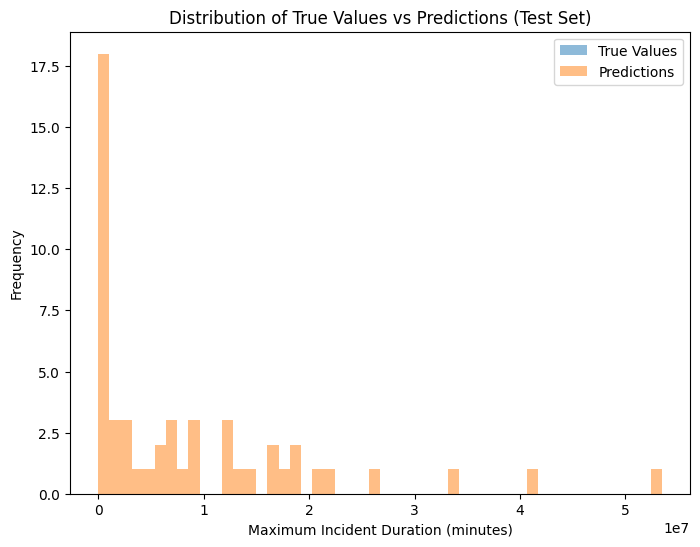

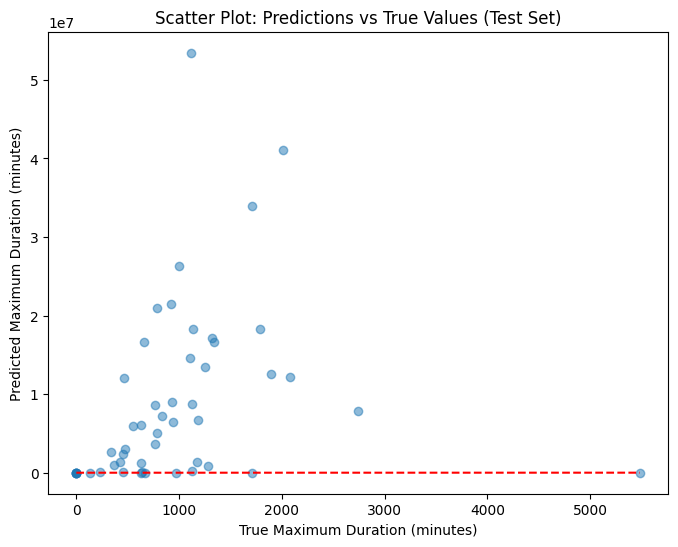

In [14]:
import matplotlib.pyplot as plt

# Convert predictions and true values back to CPU for plotting
predictions_np = predictions.cpu().numpy()
true_values_np = true_values.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.hist(true_values_np, bins=50, alpha=0.5, label='True Values')
plt.hist(predictions_np, bins=50, alpha=0.5, label='Predictions')
plt.xlabel('Maximum Incident Duration (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of True Values vs Predictions (Test Set)')
plt.show()

# Also, scatter plot for a more detailed view
plt.figure(figsize=(8, 6))
plt.scatter(true_values_np, predictions_np, alpha=0.5)
plt.plot([min(true_values_np), max(true_values_np)], [min(true_values_np), max(true_values_np)], 'r--')
plt.xlabel('True Maximum Duration (minutes)')
plt.ylabel('Predicted Maximum Duration (minutes)')
plt.title('Scatter Plot: Predictions vs True Values (Test Set)')
plt.show()


In [15]:
import numpy as np

pred_min, pred_max = np.min(predictions_np), np.max(predictions_np)
true_min, true_max = np.min(true_values_np), np.max(true_values_np)
pred_mean, pred_median = np.mean(predictions_np), np.median(predictions_np)
true_mean, true_median = np.mean(true_values_np), np.median(true_values_np)

print("Predictions - min:", pred_min, "max:", pred_max, "mean:", pred_mean, "median:", pred_median)
print("True Values - min:", true_min, "max:", true_max, "mean:", true_mean, "median:", true_median)


Predictions - min: 0.93534386 max: 53455350.0 mean: 8609021.0 median: 5074226.5
True Values - min: 0.0 max: 5484.232 mean: 960.7401 median: 784.4501


In [16]:
print("Prediction Quantiles:", np.quantile(predictions_np, [0.25, 0.5, 0.75]))
print("True Value Quantiles:", np.quantile(true_values_np, [0.25, 0.5, 0.75]))


Prediction Quantiles: [   51392.63085938  5074226.5        13018129.5       ]
True Value Quantiles: [ 458.79502869  784.45007324 1175.40484619]


In [17]:
import io, base64

buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img_str = base64.b64encode(buf.read()).decode('utf-8')
print(img_str)


iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAIyUlEQVR4nO3WMQEAIAzAMMC/5+ECjiYKenbPzCwAADLO7wAAAN4ygAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAA

<Figure size 640x480 with 0 Axes>

In [18]:
import torch.optim as optim
import torch.nn.functional as F

# ------------------------------
# Final Hyperparameters from Grid Search (Best Found)
# ------------------------------
best_lr = 0.005
best_hidden_channels = 64
best_num_layers = 3
best_dropout_rate = 0.3
best_weight_decay = 1e-4
num_epochs = 200
patience = 20
clip_norm = 5.0  # Gradient clipping norm

# ------------------------------
# Reinitialize the Final Model with Best Hyperparameters
# ------------------------------
final_model = MultiLayerWeightedHeteroGNN(
    in_channels=in_channels,
    hidden_channels=best_hidden_channels,
    out_channels=1,  # Regression output
    edge_attr_dims=edge_attr_dims,
    num_layers=best_num_layers,
    dropout_rate=best_dropout_rate
).to(device)

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

# Use SmoothL1Loss (Huber loss) as a robust loss function
criterion = torch.nn.SmoothL1Loss()

best_val_loss = float('inf')
counter = 0

# ------------------------------
# Final Training Loop with Huber Loss and Gradient Clipping
# ------------------------------
for epoch in range(1, num_epochs + 1):
    final_model.train()
    optimizer.zero_grad()
    
    # Forward pass: predictions are in log-space
    out = final_model(hetero_graph)
    train_loss = criterion(out[train_mask], hetero_graph['substation'].y[train_mask])
    train_loss.backward()
    
    # Gradient clipping to stabilize training
    torch.nn.utils.clip_grad_norm_(final_model.parameters(), clip_norm)
    
    optimizer.step()
    
    final_model.eval()
    with torch.no_grad():
        out_val = final_model(hetero_graph)
        val_loss = criterion(out_val[val_mask], hetero_graph['substation'].y[val_mask])
    
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        torch.save(final_model.state_dict(), 'best_final_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train SmoothL1 Loss (log-space): {train_loss.item():.4f} | Val SmoothL1 Loss (log-space): {val_loss.item():.4f}")

# ------------------------------
# Load Best Model and Evaluate on Test Set
# ------------------------------
final_model.load_state_dict(torch.load('best_final_model.pth'))
final_model.eval()

with torch.no_grad():
    out = final_model(hetero_graph)  # predictions in log-space
    test_loss = criterion(out[test_mask], hetero_graph['substation'].y[test_mask])
    
    # Convert predictions back to original scale: original = exp(log_value) - 1
    predictions = torch.exp(out[test_mask]) - 1
    true_values = torch.exp(hetero_graph['substation'].y[test_mask]) - 1
    
    # Compute RMSE on the original scale
    final_rmse = torch.sqrt(torch.mean((predictions - true_values) ** 2))

print(f"\nFinal Test SmoothL1 Loss (log-space): {test_loss.item():.4f}")
print(f"Final Test RMSE (original scale): {final_rmse.item():.4f}")


Epoch 10/200 - Train SmoothL1 Loss (log-space): 4.1964 | Val SmoothL1 Loss (log-space): 2.1755
Epoch 20/200 - Train SmoothL1 Loss (log-space): 2.5755 | Val SmoothL1 Loss (log-space): 1.2872
Epoch 30/200 - Train SmoothL1 Loss (log-space): 1.1390 | Val SmoothL1 Loss (log-space): 4.8138
Early stopping triggered!

Final Test SmoothL1 Loss (log-space): 0.8899
Final Test RMSE (original scale): 2586.9434


Percentage of zeros (log(y+1)==0) in Training set: 10.55%
Percentage of zeros (log(y+1)==0) in Validation set: 25.49%
Percentage of zeros (log(y+1)==0) in Test set: 9.80%


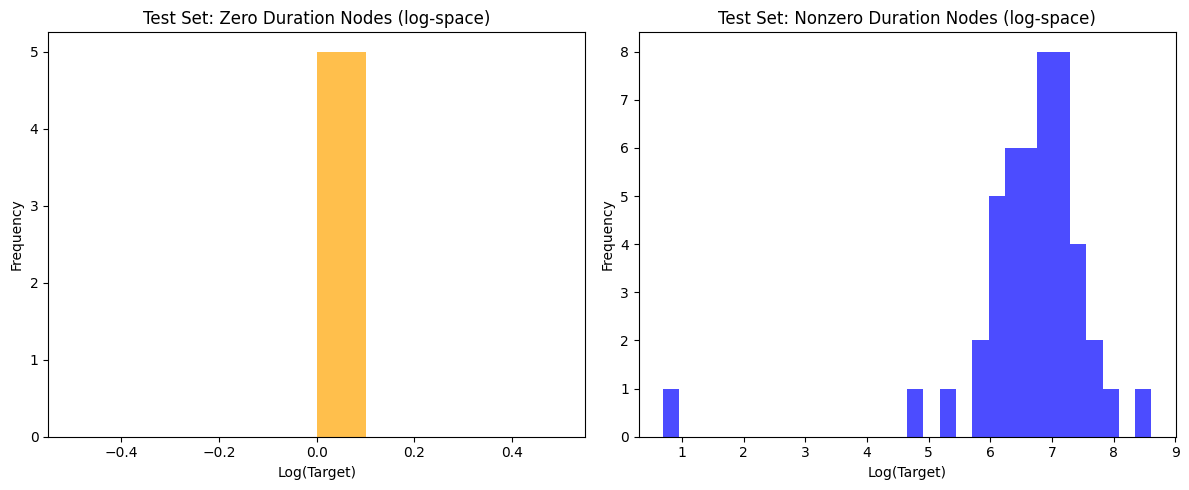

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate percentage of zeros in each split
train_zero_pct = np.mean(train_targets == 0) * 100
val_zero_pct = np.mean(val_targets == 0) * 100
test_zero_pct = np.mean(test_targets == 0) * 100

print(f"Percentage of zeros (log(y+1)==0) in Training set: {train_zero_pct:.2f}%")
print(f"Percentage of zeros (log(y+1)==0) in Validation set: {val_zero_pct:.2f}%")
print(f"Percentage of zeros (log(y+1)==0) in Test set: {test_zero_pct:.2f}%")

# Separate nonzero and zero targets for the test set (for example)
nonzero_test = test_targets[test_targets != 0]
zero_test = test_targets[test_targets == 0]

# Plot histograms for nonzero and zero test targets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(zero_test, bins=10, color="orange", alpha=0.7)
plt.title("Test Set: Zero Duration Nodes (log-space)")
plt.xlabel("Log(Target)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(nonzero_test, bins=30, color="blue", alpha=0.7)
plt.title("Test Set: Nonzero Duration Nodes (log-space)")
plt.xlabel("Log(Target)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

# ======================================================
# 1. Create a Classification Model for Zero vs. Non-Zero
# ======================================================
class ZeroClassifierGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_attr_dims, num_layers=2, dropout_rate=0.5):
        super().__init__()
        self.model = MultiLayerWeightedHeteroGNN(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=1,  # single logit for binary classification
            edge_attr_dims=edge_attr_dims,
            num_layers=num_layers,
            dropout_rate=dropout_rate
        )

    def forward(self, data):
        # Outputs a single logit per node
        return self.model(data).squeeze()

# ======================================================
# 2. Create a Regression Model for Non-Zero Durations
# ======================================================
class DurationRegressorGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_attr_dims, num_layers=2, dropout_rate=0.5):
        super().__init__()
        self.model = MultiLayerWeightedHeteroGNN(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=1,  # log-space regression output
            edge_attr_dims=edge_attr_dims,
            num_layers=num_layers,
            dropout_rate=dropout_rate
        )

    def forward(self, data):
        # Outputs log(duration+1) for each node (squeezed)
        return self.model(data).squeeze()

# ======================================================
# 3. Prepare Classification Target
# ======================================================
# 'substation'.y currently has log(duration+1). 
# is_zero = 1 if duration == 0 => log(1) == 0
is_zero_target = (hetero_graph['substation'].y == 0).float()

# ======================================================
# 4. Split the Masks for Classification vs. Regression
# ======================================================
# The same train_mask, val_mask, test_mask from the original pipeline
train_zero_mask = train_mask  # for classification, we use all nodes
val_zero_mask   = val_mask
test_zero_mask  = test_mask

# For regression, we only train on nodes with NON-zero duration
train_nonzero_mask = train_mask & (is_zero_target == 0)
val_nonzero_mask   = val_mask & (is_zero_target == 0)
test_nonzero_mask  = test_mask  # We'll still evaluate on all test nodes, but we only train regression on non-zero

# For regression, the target is log(duration+1), but only for non-zero nodes
duration_target = hetero_graph['substation'].y  # log-space

# ======================================================
# 5. Hyperparams for Both Stages
# ======================================================
in_channels = hetero_graph['substation'].x.size(1)
edge_attr_dims = {
    'spatial': 3,
    'temporal': 2,
    'causal': 3
}

lr = 0.005
weight_decay = 1e-4
hidden_channels = 64
num_layers = 3
dropout_rate = 0.3
max_epochs = 200
patience = 20
clip_norm = 5.0

# ======================================================
# 6. Train the Classification Model (Stage 1)
# ======================================================
classifier = ZeroClassifierGNN(
    in_channels, hidden_channels, edge_attr_dims,
    num_layers=num_layers, dropout_rate=dropout_rate
).to(device)

optimizer_cls = optim.Adam(classifier.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cls = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cls, mode='min', patience=10, factor=0.5, verbose=False)

criterion_cls = nn.BCEWithLogitsLoss()

best_val_loss_cls = float('inf')
patience_counter_cls = 0

for epoch in range(1, max_epochs+1):
    classifier.train()
    optimizer_cls.zero_grad()
    logits = classifier(hetero_graph)  # shape: [num_nodes]
    
    train_loss_cls = criterion_cls(
        logits[train_zero_mask],
        is_zero_target[train_zero_mask]
    )
    train_loss_cls.backward()
    clip_grad_norm_(classifier.parameters(), clip_norm)
    optimizer_cls.step()

    # Validation
    classifier.eval()
    with torch.no_grad():
        val_logits = classifier(hetero_graph)
        val_loss_cls = criterion_cls(
            val_logits[val_zero_mask],
            is_zero_target[val_zero_mask]
        )
    scheduler_cls.step(val_loss_cls)

    if val_loss_cls < best_val_loss_cls:
        best_val_loss_cls = val_loss_cls.item()
        patience_counter_cls = 0
        torch.save(classifier.state_dict(), 'best_classifier.pth')
    else:
        patience_counter_cls += 1
        if patience_counter_cls >= patience:
            print("Early stopping triggered for Classification!")
            break

    if epoch % 10 == 0:
        print(f"[Classification] Epoch {epoch}/{max_epochs} - Train Loss: {train_loss_cls.item():.4f}, Val Loss: {val_loss_cls.item():.4f}")

# Load best classifier
classifier.load_state_dict(torch.load('best_classifier.pth'))
classifier.eval()

# ======================================================
# 7. Train the Regression Model (Stage 2)
# ======================================================
regressor = DurationRegressorGNN(
    in_channels, hidden_channels, edge_attr_dims,
    num_layers=num_layers, dropout_rate=dropout_rate
).to(device)

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_reg = optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', patience=10, factor=0.5, verbose=False)

# You can use MSELoss or SmoothL1Loss here; we'll do SmoothL1Loss for robustness
criterion_reg = nn.SmoothL1Loss()

best_val_loss_reg = float('inf')
patience_counter_reg = 0

for epoch in range(1, max_epochs+1):
    regressor.train()
    optimizer_reg.zero_grad()
    reg_out = regressor(hetero_graph)  # shape: [num_nodes] in log-space

    # We only compute loss on non-zero nodes in the training set
    train_loss_reg = criterion_reg(
        reg_out[train_nonzero_mask],
        duration_target[train_nonzero_mask]
    )
    train_loss_reg.backward()
    clip_grad_norm_(regressor.parameters(), clip_norm)
    optimizer_reg.step()

    # Validation
    regressor.eval()
    with torch.no_grad():
        val_out = regressor(hetero_graph)
        val_loss_reg = criterion_reg(
            val_out[val_nonzero_mask],
            duration_target[val_nonzero_mask]
        )
    scheduler_reg.step(val_loss_reg)

    if val_loss_reg < best_val_loss_reg:
        best_val_loss_reg = val_loss_reg.item()
        patience_counter_reg = 0
        torch.save(regressor.state_dict(), 'best_regressor.pth')
    else:
        patience_counter_reg += 1
        if patience_counter_reg >= patience:
            print("Early stopping triggered for Regression!")
            break

    if epoch % 10 == 0:
        print(f"[Regression] Epoch {epoch}/{max_epochs} - Train Loss: {train_loss_reg.item():.4f}, Val Loss: {val_loss_reg.item():.4f}")

# Load best regressor
regressor.load_state_dict(torch.load('best_regressor.pth'))
regressor.eval()

# ======================================================
# 8. Final Inference: Combine Classifier + Regressor
# ======================================================
with torch.no_grad():
    # 1) Classification predictions (logits -> probability)
    cls_logits = classifier(hetero_graph)
    cls_probs = torch.sigmoid(cls_logits)
    # If cls_probs >= 0.5 => zero predicted, else non-zero

    # 2) Regression predictions in log-space
    reg_preds_log = regressor(hetero_graph)
    reg_preds_minutes = torch.exp(reg_preds_log) - 1  # convert back to original scale

# Combine predictions:
# If predicted zero => final prediction = 0
# Otherwise => use regression prediction
final_predictions = torch.zeros_like(reg_preds_minutes)
final_predictions[cls_probs < 0.5] = reg_preds_minutes[cls_probs < 0.5]

# True values (original scale)
true_log = hetero_graph['substation'].y
true_minutes = torch.exp(true_log) - 1

# Evaluate on test set
test_preds = final_predictions[test_mask]
test_true = true_minutes[test_mask]

rmse = torch.sqrt(torch.mean((test_preds - test_true) ** 2))
print(f"\nFinal Two-Stage Model RMSE (original scale): {rmse.item():.4f} minutes")


[Classification] Epoch 10/200 - Train Loss: 0.2154, Val Loss: 0.2600
[Classification] Epoch 20/200 - Train Loss: 0.1125, Val Loss: 0.2617
[Classification] Epoch 30/200 - Train Loss: 0.0908, Val Loss: 0.2539
[Classification] Epoch 40/200 - Train Loss: 0.0731, Val Loss: 0.2387
[Classification] Epoch 50/200 - Train Loss: 0.0655, Val Loss: 0.2554
[Classification] Epoch 60/200 - Train Loss: 0.0544, Val Loss: 0.2528
Early stopping triggered for Classification!
[Regression] Epoch 10/200 - Train Loss: 4.4362, Val Loss: 4.5479
[Regression] Epoch 20/200 - Train Loss: 2.7736, Val Loss: 2.3815
[Regression] Epoch 30/200 - Train Loss: 1.0467, Val Loss: 1.4524
[Regression] Epoch 40/200 - Train Loss: 0.7340, Val Loss: 1.5448
[Regression] Epoch 50/200 - Train Loss: 0.6972, Val Loss: 0.7302
[Regression] Epoch 60/200 - Train Loss: 0.4952, Val Loss: 0.5071
[Regression] Epoch 70/200 - Train Loss: 0.4927, Val Loss: 0.4598
[Regression] Epoch 80/200 - Train Loss: 0.5301, Val Loss: 0.4408
Early stopping trigge